### I. Librairies

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
random_state = 42

Using TensorFlow backend.


### II. Data Loading

##### II.a Digits

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
digits_X=np.concatenate((X_train,X_test))
digits_y=np.concatenate((y_train,y_test))

##### II.b Letters

In [3]:
letters_data=pd.read_csv("Data/A_Z_Handwritten_Data.csv",header=None)
letters_X=letters_data.iloc[:,1:].values
letters_X = letters_X.reshape(letters_X.shape[0], 28, 28)
letters_y=letters_data.iloc[:,0].values
letters_y=letters_y+10 #digits' labels first

##### II.c Concatenation

In [4]:
X = np.concatenate((digits_X, letters_X))
y = np.concatenate((digits_y, letters_y))
print(f"X shape: {X.shape}")
print(f"Y shape: {y.shape}")

X shape: (442451, 28, 28)
Y shape: (442451,)


##### II.d Normalisation and reshaping

In [5]:
X = X / 255
X = X.reshape(X.shape[0], 28, 28, 1) #for keras

##### II.e Display

In [6]:
def labelToChar(label):
    if label < 10:
        return chr(label + 48)
    return chr(label + 55)

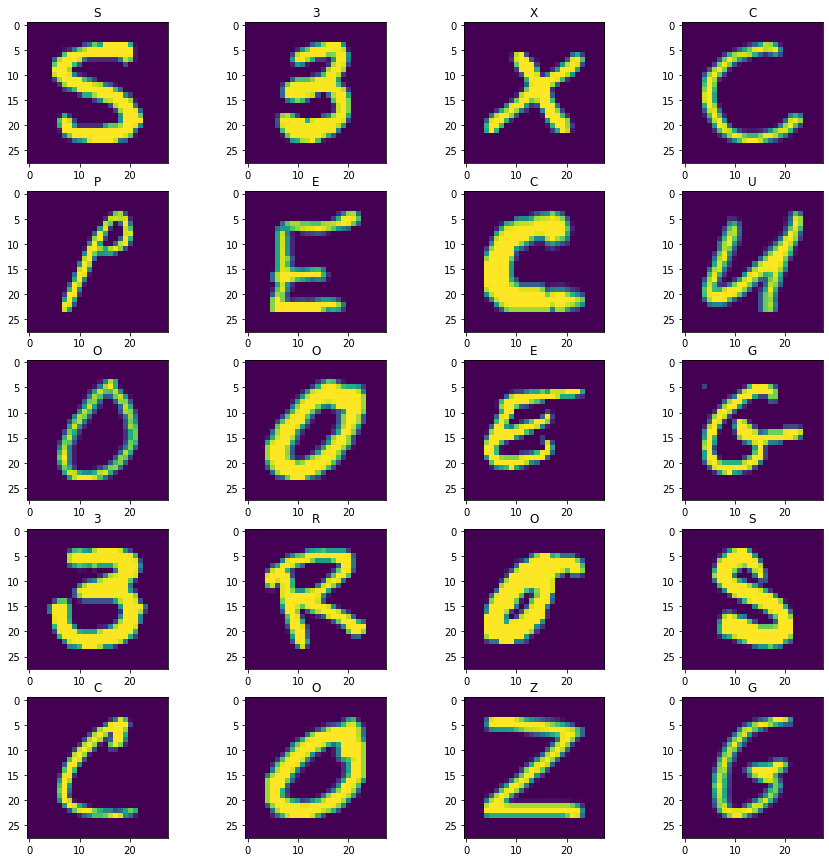

In [7]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    i_img = np.random.randint(0, X.shape[0])
    plt.imshow(np.array(X[i_img]).reshape(28,28))
    plt.title(labelToChar(y[i_img]))
plt.show()

##### II.f Set separation

In [8]:
y_cat=to_categorical(y)

X_train, X_validation, y_train, y_validation = train_test_split(X, y_cat, train_size = 0.7,
                                                                random_state = random_state,
                                                                stratify = y_cat, shuffle = True)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, train_size = 0.6,
                                                                random_state = random_state,
                                                                stratify = y_validation, shuffle = True)
print(f"Train/Validation/Test size: {X_train.shape[0]}/{X_validation.shape[0]}/{X_test.shape[0]}")

Train/Validation/Test size: 309715/79641/53095


### III Training

In [16]:
model=Sequential()

model.add(Conv2D(64,(5,5),input_shape=(28,28,1),activation='relu', data_format="channels_last", padding="same"))
model.add(Conv2D(64,(5,5),activation='relu', data_format="channels_last", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3),activation='relu', data_format="channels_last", padding="same"))
model.add(Conv2D(128,(3,3),activation='relu', data_format="channels_last", padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)        

In [17]:
model.fit(X_train, y_train, batch_size = 256, epochs = 5, validation_data = (X_validation, y_validation))

Train on 309715 samples, validate on 79641 samples
Epoch 1/5
309715/309715 [==============================] - 44s 141us/step - loss: 0.2391 - accuracy: 0.9341 - val_loss: 0.0982 - val_accuracy: 0.9731
Epoch 2/5
309715/309715 [==============================] - 42s 137us/step - loss: 0.0810 - accuracy: 0.9767 - val_loss: 0.0649 - val_accuracy: 0.9821
Epoch 3/5
309715/309715 [==============================] - 43s 138us/step - loss: 0.0596 - accuracy: 0.9828 - val_loss: 0.0593 - val_accuracy: 0.9839
Epoch 4/5
309715/309715 [==============================] - 43s 138us/step - loss: 0.0489 - accuracy: 0.9856 - val_loss: 0.0497 - val_accuracy: 0.9861
Epoch 5/5
309715/309715 [==============================] - 43s 138us/step - loss: 0.0406 - accuracy: 0.9877 - val_loss: 0.0495 - val_accuracy: 0.9862


### IV. Test

In [12]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = 0)
print(f"Train loss: {loss:.3f} Train accuracy: {100*accuracy:.2f}")
loss, accuracy = model.evaluate(X_validation, y_validation, verbose = 0)
print(f"Validation loss: {loss:.3f} Validation accuracy: {100*accuracy:.2f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose = 0)
print(f"Test loss: {loss:.3f} Test accuracy: {100*accuracy:.2f}")


Train loss: 0.028 Train accuracy: 99.12
Validation loss: 0.050 Validation accuracy: 98.62
Test loss: 0.053 Test accuracy: 98.54


### V. Save model

In [20]:
model_name = "character_model"
folder = 'Models/'

# serialize model to JSON
model_json = model.to_json()
with open(f"{folder}{model_name}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{folder}{model_name}.h5")
print("Saved model to disk")

Saved model to disk


### VI Load a saved Model

In [11]:
from keras.models import model_from_json

model_name = "character_model"
folder = 'Models/'

# load json and create model
json_file = open(f"{folder}{model_name}.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f"{folder}{model_name}.h5")
print("Loaded model from disk")
 
# compile the model to be able to use it
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Loaded model from disk
